**Interos Take Home Assignment-EDA**

**Raul Andrial**

In this notebook, I implemented a model that classifies articles if they are of the type "earn" or not. The data provided to me was from the Reuters-21578, Distribution 1.0 dataset originally found at http://www.research.att.com/~lewis.

In [ ]:
# Before running this notebook, please make sure a shortcut has been created
# under 'My Drive' for the shared project folder.
#
# Then, please insert path to shortcut from 'My Drive' below in path_to project.
#

path_to_project = r'Raul_Andrial_Interos_Take_Home_ML_Apprentice'

from google.colab import drive
mnt_loc = r'/content/drive'
drive.mount(mnt_loc)

# This allows relative paths to be set when exporting data or importing
# dependencies from gdrive.
#

import os

os.chdir(f'{mnt_loc}/My Drive/{path_to_project}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Not installed by default in Google Colab
# Used to convert xml text to a python dictionary
# https://pypi.org/project/xmltodict/
#

import Dependencies.xmltodict

In [ ]:
# From my github account from a prior project
# https://github.com/randr000/MyPythonScripts/blob/main/useful_functions.py
# Useful function for exploring dataframes

def unique_values(series):
    """Takes a Pandas Series and returns a DataFrame with all unique values and their counts"""
    
    return series.value_counts(dropna=False).rename_axis('Unique Values').reset_index(name='Counts')

def print_row_count(dframe):
    """Takes a dataframe and prints out the total number of rows in a formatted string."""
    
    row_count = len(dframe)
    print('Current Row Count: {:,}'.format(row_count))
    
def count_null(series):
    """Takes a series and counts and prints the number of null and not null values"""
    
    print("Series name: {}".format(series.name))
    print("The number of missing values is {:,}.".format(series.isnull().sum()))
    print("The number of not null values is {:,}.".format(series.notnull().sum()))

In [ ]:
# Path within gdrive to where data was stored
folder_path = f'{path_to_project}/reuters21578'
# folder_path = r'/My Drive/test'

# Joined mount_loc and folder_path locations
data_path = f'{mnt_loc}/My Drive/{folder_path}'

# File extension of data to use.
# ex. .xml, .sgm, etc.
file_ext = '.sgm'

In [ ]:
for file in os.listdir(data_path):
  if file.endswith(file_ext):
    print(file)

reut2-000.sgm
reut2-001.sgm
reut2-002.sgm
reut2-004.sgm
reut2-003.sgm
reut2-005.sgm
reut2-006.sgm
reut2-007.sgm
reut2-009.sgm
reut2-008.sgm
reut2-010.sgm
reut2-011.sgm
reut2-012.sgm
reut2-013.sgm
reut2-015.sgm
reut2-014.sgm
reut2-016.sgm
reut2-017.sgm
reut2-018.sgm
reut2-019.sgm
reut2-020.sgm


In [ ]:
# Looped through all .sgm files in the directory specified.
xml_string = ''
for file in os.listdir(data_path):
  if file.endswith(file_ext):
    with open(f'{data_path}/{file}', 'rb') as f:
      # Read xml data from current open file and append to xml_string.
      xml_append = f.read().decode('utf-8', 'ignore')
      xml_string = f'{xml_string}{xml_append}'

# Removed control characters and other special characters.
# Control characters were causing errors in parsing the xml text.
xml_string = re.sub(r'&#\d{1,2};', '', xml_string)

# Removed all 'DOCTYPE' declarations in concatenated string.
xml_string = re.sub(r'<!DOCTYPE.*>', '', xml_string)

# Add 'lewis' root tags, from dtd file, in order to parse xml as well as original DOCTYPE declaration.
xml_string = f'<!DOCTYPE lewis SYSTEM "lewis.dtd"><lewis>{xml_string}</lewis>'

# Parsed xml string and converted to dictionary.
xml_dict = Dependencies.xmltodict.parse(xml_string)

In [ ]:
# Dictionary paths to relevant data:
#
#   xml_dict['lewis']['REUTERS']
#     A list containing all the articles.
#
#   xml_dict['lewis']['REUTERS'][index]['@TOPICS']
#     'YES' or 'NO' depending on if the article has at least on topic associated with it.
#
#   xml_dict['lewis']['REUTERS'][index]['TOPICS']['D']
#     This is where the article's topics go. An article can have one, more than one, or no topics.
#     If an article has not topics, there are no 'D' tags.
#
#   xml_dict['lewis']['REUTERS'][index]['TEXT']['BODY']
#     Contains the text of the article's body.
#

# List of all articles
articles = xml_dict['lewis']['REUTERS']

# Below, a dataframe was created containing the values of the three attributes listed above.
#
# I used the link below to help me solve a bug I was having with the list comprehensions.
#
# https://stackoverflow.com/questions/26264359/why-is-this-list-comprehension-giving-me-a-syntax-error
# 

df = pd.DataFrame({
    
    'has_topic' : [article['@TOPICS'] for article in articles],

    # If there were multiple topics, they were joined together as one string using ',' as the delimiter.
    'topic': [None if article['TOPICS'] is None else ','.join(article['TOPICS']['D']) \
                if type(article['TOPICS']['D']) is list else article['TOPICS']['D'] for article in articles],
              
    'article_text' : [article['TEXT']['BODY'] if 'BODY' in article['TEXT'] else None for article in articles]
})

There were 21 files and 1,000 articles per file, so as a sanity check, I made sure the total rows in the dataframe were 21,000.

In [ ]:
print_row_count(df)

Current Row Count: 21,000


Below, one can see at index 7 that has_topic is not always correct so this column was removed. Also, since it is not possible to classify an article if it has no topics or body text, all rows with missing values were removed.

In [ ]:
df.head(10)

,has_topic,topic,article_text
0,YES,cocoa,Showers continued throughout the week in\nthe ...
1,NO,None,Standard Oil Co and BP North America\nInc said...
2,NO,None,Texas Commerce Bancshares Inc's Texas\nCommerc...
3,NO,None,BankAmerica Corp is not under\npressure to act...
4,YES,"grain,wheat,corn,barley,oat,sorghum",The U.S. Agriculture Department\nreported the ...
5,YES,"veg-oil,linseed,lin-oil,soy-oil,sun-oil,soybea...",Argentine grain board figures show\ncrop regis...
6,NO,None,Red Lion Inns Limited Partnership\nsaid it fil...
7,YES,None,Moody's Investors Service Inc said it\nlowered...
8,YES,earn,Champion Products Inc said its\nboard of direc...
9,YES,acq,Computer Terminal Systems Inc said\nit has com...


In [ ]:
unique_values(df['has_topic'])

,Unique Values,Counts
0,YES,13146
1,NO,6811
2,BYPASS,1043


In [ ]:
count_null(df['topic'])

Series name: topic
The number of missing values is 9,962.
The number of not null values is 11,038.


In [ ]:
count_null(df['article_text'])

Series name: article_text
The number of missing values is 2,417.
The number of not null values is 18,583.


In [ ]:
df = df.drop(columns='has_topic')
df = df.dropna()

In [ ]:
print_row_count(df)

Current Row Count: 10,083


The text in the article_text column contains the newline character "\n" where there was a line break in the original .sgm files. The code below replaced them with one blank space for each.

In [ ]:
df['article_text'].head()

0    Showers continued throughout the week in\nthe ...
4    The U.S. Agriculture Department\nreported the ...
5    Argentine grain board figures show\ncrop regis...
8    Champion Products Inc said its\nboard of direc...
9    Computer Terminal Systems Inc said\nit has com...
Name: article_text, dtype: object

In [ ]:
df['article_text'] = df['article_text'].str.replace(r'\n', ' ')

In [ ]:
df['article_text'].head()

0    Showers continued throughout the week in the B...
4    The U.S. Agriculture Department reported the f...
5    Argentine grain board figures show crop regist...
8    Champion Products Inc said its board of direct...
9    Computer Terminal Systems Inc said it has comp...
Name: article_text, dtype: object

Since the challenge is asking to at least classify news articles of type "earn", I created a column where 'True' means an article is of the type "earn" and 'False' means it is not.

In [ ]:
df['earn_topic'] = df['topic'].apply(lambda x: True if 'earn' in x else False)

Since it is possible for an article to have multiple topics, I created a column where 'True' means the article has more than one topic and 'False' means it only has one.

In [ ]:
df['multi_topic'] = df['topic'].apply(lambda x: True if ',' in x else False)

In [ ]:
df.head(10)

,topic,article_text,earn_topic,multi_topic
0,cocoa,Showers continued throughout the week in the B...,False,False
4,"grain,wheat,corn,barley,oat,sorghum",The U.S. Agriculture Department reported the f...,False,True
5,"veg-oil,linseed,lin-oil,soy-oil,sun-oil,soybea...",Argentine grain board figures show crop regist...,False,True
8,earn,Champion Products Inc said its board of direct...,True,False
9,acq,Computer Terminal Systems Inc said it has comp...,False,False
10,earn,"Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,8...",True,False
11,"earn,acq","Ohio Mattress Co said its first quarter, endin...",True,True
12,earn,Oper shr loss two cts vs profit seven cts ...,True,False
13,earn,Shr one dlr vs 73 cts Net 12.6 mln vs 15.8...,True,False
17,earn,Dean Foods Co expects earnings for the fourth ...,True,False


Some of the articles were about multiple topics where "earn" was one of them. They represented less that half of one percent of the total remaining records, so they were removed and were excluded from training and testing.

In [ ]:
earn_multi = len(df[(df['earn_topic'] == True) & (df['multi_topic'] == True)])
pct =  earn_multi / len(df)
print(f'The total number of rows where there are multiple topics and "earn" is one of them is: {earn_multi}.')
print(f'That represents {pct:.2%} of the total current number of records in the dataframe.')

The total number of rows where there are multiple topics and "earn" is one of them is: 41.
That represents 0.41% of the total current number of records in the dataframe.


In [ ]:
# Removed records where 'earn_topic' and 'multi_topic' are both equal to 'True'.
df = df[~((df['earn_topic'] == True) & (df['multi_topic'] == True))]

In [ ]:
print_row_count(df)

Current Row Count: 10,042


For the remaining records, about 64% percent of them did not have "earn" as a topic and about 36% did. The data was not extremely out of balance so no over or undersampling was conducted.

In [ ]:
unique_values(df['earn_topic'])

,Unique Values,Counts
0,False,6457
1,True,3585


Below are the next steps I took to prepare the articles' text for model training. Stemming was chosen over lemmatization since it is simpler and is faster. This decision would have been revisted if model performance was poor.

In [ ]:
# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
#
# From my github account from a prior project
# https://github.com/randr000/MyPythonJupyterNotebooks/blob/main/Twitter%20Tweepy%20Data%20Cleaning%20for%20Text%20Mining.ipynb
#

# Created a copy of the article_text column and cleaned the data in the new copy
df['cleaned_text'] = df['article_text']

# Made every letter lowercase
df['cleaned_text'] = df['cleaned_text'].str.lower()

# Removed all hyperlinks
df['cleaned_text'] = df['cleaned_text'].str.replace(r'(https?:/?/?\S+)', '', flags=re.IGNORECASE)

# Removed any leading and trailing whitespace
df['cleaned_text'] = df['cleaned_text'].str.strip()

# Removed all punctuation
df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^\w\s]', '')

# Removed any numbers
df['cleaned_text'] = df['cleaned_text'].str.replace(r'\d', '')

# Tokenized text
tokenizer = RegexpTokenizer(r'\w+')
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: tokenizer.tokenize(x))

# Removed stop words
def remove_stop_words(text, stop_words):
  return [w for w in text if w not in stop_words]

stop = stopwords.words('english')
df['cleaned_text'] = df['cleaned_text'].apply(remove_stop_words, stop_words=stop)

# Stemmed all words
ps = PorterStemmer()

def stem_words(text):
  return [ps.stem(w) for w in text]

df['cleaned_text'] = df['cleaned_text'].apply(stem_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,topic,article_text,earn_topic,multi_topic,cleaned_text
0,cocoa,Showers continued throughout the week in the B...,False,False,"[shower, continu, throughout, week, bahia, coc..."
4,"grain,wheat,corn,barley,oat,sorghum",The U.S. Agriculture Department reported the f...,False,True,"[us, agricultur, depart, report, farmerown, re..."
5,"veg-oil,linseed,lin-oil,soy-oil,sun-oil,soybea...",Argentine grain board figures show crop regist...,False,True,"[argentin, grain, board, figur, show, crop, re..."
8,earn,Champion Products Inc said its board of direct...,True,False,"[champion, product, inc, said, board, director..."
9,acq,Computer Terminal Systems Inc said it has comp...,False,False,"[comput, termin, system, inc, said, complet, s..."


There were other words that were extremely common in both the "earn" and "not earn" type articles. The code below determined what those words were and removed them from all records.

In [ ]:
def count_words(lst, count_dict):
  """Counts words in a list and adds them to dictionary passed as arguement"""
  for word in lst:
    if word not in count_dict:
      count_dict[word] = 1
    else:
      count_dict[word] += 1

def calc_word_pct(i, total):
  """Calculates the percentage of the total word count for the current word"""
  return (i / total) * 100

earn_df = df[df['earn_topic'] == True]
not_earn_df = df[df['earn_topic'] == False]

# Dictionaries where a word is the key and its count is the value.
earn_word_count = {}
not_earn_word_count = {}

# Calculated the word counts and populated the dictionaries.
earn_df['cleaned_text'].apply(count_words, count_dict=earn_word_count)
not_earn_df['cleaned_text'].apply(count_words, count_dict=not_earn_word_count)

# Sorted lists of tuples in descending order containing each word and its count.
earn_lst = sorted(earn_word_count.items(), key=lambda x: x[1], reverse=True)
not_earn_lst = sorted(not_earn_word_count.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Created dataframe for the "earn" article word counts as well as calculated a word's
# overall count percentage.
#

earn_df_wc = pd.DataFrame(earn_lst, columns=['word', 'earn_count'])
earn_df_wc.set_index('word', inplace=True)
earn_count_sum = earn_df_wc['earn_count'].sum()
earn_df_wc['earn_count_pct'] = earn_df_wc['earn_count'].apply(calc_word_pct, total=earn_count_sum)
earn_df_wc.head()

,earn_count,earn_count_pct
word,,
vs,13101,7.928084
mln,10535,6.375266
ct,7461,4.515032
dlr,5932,3.589756
net,4780,2.892622


In [ ]:
# Created dataframe for the "not earn" article word counts as well as calculated a word's
# overall count percentage.
#

not_earn_df_wc = pd.DataFrame(not_earn_lst, columns=['word', 'not_earn_count'])
not_earn_df_wc.set_index('word', inplace=True)
not_earn_count_sum = not_earn_df_wc['not_earn_count'].sum()
not_earn_df_wc['not_earn_count_pct'] = not_earn_df_wc['not_earn_count'].apply(calc_word_pct, total=not_earn_count_sum)
not_earn_df_wc.head()

,not_earn_count,not_earn_count_pct
word,,
said,23378,3.551835
pct,8373,1.272115
dlr,7042,1.069896
mln,6974,1.059564
reuter,6949,1.055766


In [ ]:
# Merged the two word count dataframes created above.
word_count_df = pd.concat([earn_df_wc, not_earn_df_wc], axis=1)

# Calculated the percentage difference between the "earn" and "not earn" word counts.
# A value of 0 would indicate a word appears in both article type with the same ratio.
#
word_count_df['pct_diff'] = abs(word_count_df['earn_count_pct'] - word_count_df['not_earn_count_pct'])

# Created a list of stemmed stop words to be removed from "earn" and "not earn" corpuses.
my_stemmed_stop_words = word_count_df[word_count_df['pct_diff'] < 1].index

In [ ]:
# Exported my_stemmed_stop_words for cleaning future test data.

with open('Dependencies/my_stop_words.py', 'w') as f:
  f.write('my_stop_words = [\n')
  for w in my_stemmed_stop_words:
    f.write(f'"{w}",\n')
  f.write(']')

In [ ]:
# Removed additional stop words
df['cleaned_text'] = df['cleaned_text'].apply(remove_stop_words, stop_words=my_stemmed_stop_words)

In [ ]:
df[['earn_topic', 'cleaned_text']].head()

,earn_topic,cleaned_text
0,False,"[shower, bahia, cocoa, zone, allevi, drought, ..."
4,False,"[farmerown, fiveday, dlrsbusorghum, cwt, natl,..."
5,False,"[crop, oilse, thousand, bracket, wheat, maiz, ..."
8,True,"[said, said, mln, mln, reuter]"
9,False,"[said, mln, sedio, lugano, dlr, said, dlr, sai..."


Below, the text was split into training and test sets. The text was also vectorized in order to be able to use it as input for the model.

In [ ]:
# I used some ideas and code from the following links:
#
# https://datascience.stackexchange.com/questions/24376/use-of-tfidfvectorizer-on-dataframe
# https://gtraskas.github.io/post/spamit/
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
# https://towardsdatascience.com/how-to-build-and-apply-naive-bayes-classification-for-spam-filtering-2b8d3308501
# https://online.stat.psu.edu/stat507/lesson/10/10.3
# https://medium.com/@shrutisaxena0617/precision-vs-recall-386cf9f89488
# https://medium.com/@harsz89/persist-reuse-trained-machine-learning-models-using-joblib-or-pickle-in-python-76f7e4fd707
#

# Created a new dataframe with just the data needed for training and testing.
xy_df = df.loc[:, ['earn_topic', 'cleaned_text']]

# Joined each list of words under cleaned_text as strings in order to use the data
# with the TfidfVectorizer package.
#

xy_df['cleaned_text'] = [' '.join(words) for words in xy_df['cleaned_text'].values]
xy_df.head()

,earn_topic,cleaned_text
0,False,shower bahia cocoa zone allevi drought tempora...
4,False,farmerown fiveday dlrsbusorghum cwt natl ratex...
5,False,crop oilse thousand bracket wheat maiz oilse s...
8,True,said said mln mln reuter
9,False,said mln sedio lugano dlr said dlr said sedio ...


In [ ]:
vectorizer = TfidfVectorizer()

# Vectorized all data in cleaned_text.
X = vectorizer.fit_transform(xy_df['cleaned_text'])

# Set "earn_topic" as the target variable.
y = xy_df['earn_topic']

# Split data into training and test data sets.
# 80% training, 20% testing
#

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

I chose to implement a Naive Bayes classifier to create the model due to the fact that it is a simple but effective algorithm in classifying text. It is also very popular in spam filtering applications. While I am not classifying whether or not an article is spam, it is a similar problem.

In [ ]:
# Initialized model.
clf = MultinomialNB()

# Trained model using training data.
clf.fit(X_train, y_train)

# Made predictions using test data.
predictions = clf.predict(X_test)

The overall accuracy of the model was about 96.6%.

In [ ]:
print(f'Total accuracy is {accuracy_score(y_test, predictions):.2%}.')

Total accuracy is 96.57%.


Both sensitivity and specificity were above 90% and the F1 score was about .95 which indicates the model is good at classifying both types of articles.

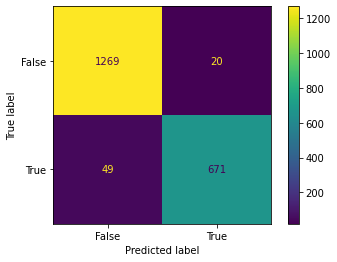

In [ ]:
# Created a confusion matrix to visualize specificity and sensitivity.

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# Printed confusion matrix value to make sure tn, tp, fn, and fp
# variables are correctly initialized.
#

print(cm)

[[1269   20]
 [  49  671]]


In [ ]:
tn, fp = cm[0]
fn, tp = cm[1]

In [ ]:

sensitivity = (tp / (tp + fn)) * 100
specificity = (tn / (tn + fp)) * 100

print(f'Sensitivity: {sensitivity:.2f}%')
print(f'Specificity: {specificity:.2f}%')

Sensitivity: 93.19%
Specificity: 98.45%


In [ ]:
precision = (tp / (tp + fp))
recall = sensitivity / 100

f1 = 2 *((precision * recall) / (precision + recall))

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9711
Recall: 0.9319
F1 Score: 0.9511


Below, I exported both the classifier model as well as the text vectorizer. This allows for both to be loaded in the future without retraining.

In [ ]:
# Exported Classifier model
joblib.dump(clf, 'Dependencies/clf_model.pkl')

# Exported vectorizer
joblib.dump(vectorizer, 'Dependencies/vectorizer.pkl')

['Dependencies/vectorizer.pkl']